> 사람의 손글씨 데이터인 MNIST를 이용해 Multi Layer Perceptron(MLP) 설계하기

In [1]:
# module import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [10]:
# 장비 확인
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')

In [2]:
BATCH_SIZE=32 # 32개의 데이터로 1개의 mini-batch를 구성, iteration : 1개의 mini-batch를 이용해 학습하는 횟수
EPOCHS=10 # 전체 데이터를 이용해 학습을 진행한 횟수

In [4]:
# MNIST 데이터 다운로드
train_dataset=datasets.MNIST(root="../data/MNIST", train=True, download=True, transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="../data/MNIST", train=False, transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw




Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 데이터 확인하기(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type()) # 32개의 이미지 데이터가 1개의 mini-batch 구성. 가로 28개, 세로 28개, 채널 1 = 흑백으로 이루어진 데이터
  print('y_train:', y_train.size(), 'type:', y_train.type()) # 32개의 이미지 데이터에 각각 label 값이 1개씩 존재
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


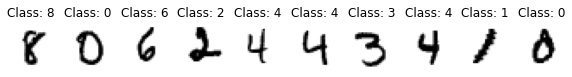

In [6]:
# 데이터 확인하기(2)
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
  plt.title('Class: '+str(y_train[i].item()))

In [9]:
# MLP 모델 설계
class Net(nn.Module): # 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 정의
  def __init__(self):
    super(Net, self).__init__()
    # fully connected layer 정의
    self.fc1=nn.Linear(28*28, 512) 
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10) # label 개수와 동일하게 설정 (원-핫 인코딩) 
  def forward(self, x):
    x=x.view(-1, 28*28) # view 메서드 이용하여 flatten
    x=self.fc1(x)
    x=F.sigmoid(x)
    x=self.fc2(x)
    x=F.sigmoid(x)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1) # softmax 이용해 확률 계산
    return x

In [11]:
# Optimizer, Objective Function 설정
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # SGD : 데이터를 조개서 Gradient Descent Method , Optimizer : 이렇게 Gradient Descent해주는 것을 통틀어
criterion=nn.CrossEntropyLoss() # 원-핫 인코딩 값 계산 위해

In [19]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader): # train_loader에는 학습에 이용되는 이미지 데이터와 레이블 데이터가 mini-batch 단위로 묶여서 저장되어있음
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad() # optimizer 초기화
    output=model(image)
    loss=criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx%log_interval==0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [27]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss+=criterion(output, label).item()
      prediction=output.max(1, keepdim=True)[1] # 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단
      correct+=prediction.eq(label.view_as(prediction)).sum().item()
  
  test_loss/=len(test_loader.dataset)
  test_accuracy=100. *correct/len(test_loader.dataset)
  return test_loss, test_accuracy

In [28]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.526383
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.244818
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.606026
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.369139
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.429595
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.375980
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.384075
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.242056
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.453829
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.481677

[EPOCH: 1], 	Test Loss: 0.0124, 	Test Accuracy: 88.53 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.724524
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.259031
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.593533
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.347266
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.306525
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.186966
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.206895
Train Epoch: 2 [448